# Anomaly detection in transactions

## Import Data and Check for Null Values, Column Info, and Descriptive Statistics

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'transaction_anomalies_dataset.csv'
data = pd.read_csv(file_path)

null_values = data.isnull().sum()

column_info = data.info()

descriptive_stats = data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               1000 non-null   object 
 1   Transaction_Amount           1000 non-null   float64
 2   Transaction_Volume           1000 non-null   int64  
 3   Average_Transaction_Amount   1000 non-null   float64
 4   Frequency_of_Transactions    1000 non-null   int64  
 5   Time_Since_Last_Transaction  1000 non-null   int64  
 6   Day_of_Week                  1000 non-null   object 
 7   Time_of_Day                  1000 non-null   object 
 8   Age                          1000 non-null   int64  
 9   Gender                       1000 non-null   object 
 10  Income                       1000 non-null   int64  
 11  Account_Type                 1000 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB


## Distribution of transactions amount in the data


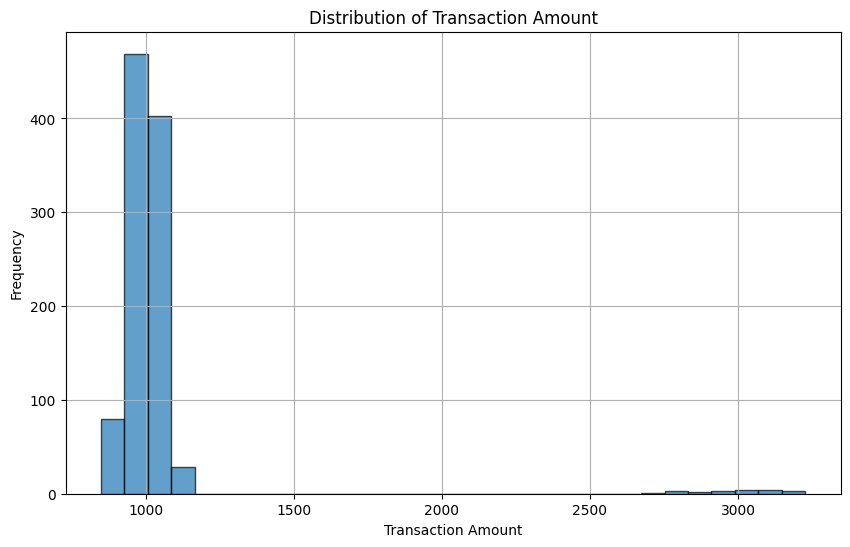

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(data["Transaction_Amount"], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Distribution of transactions amount by account type

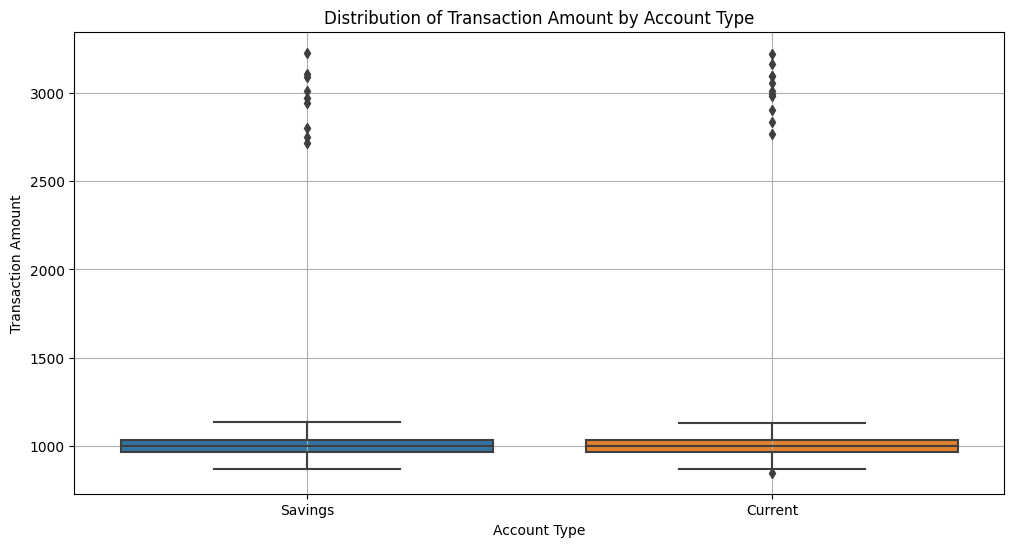

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Account_Type', y='Transaction_Amount', data=data)
plt.title('Distribution of Transaction Amount by Account Type')
plt.xlabel('Account Type')
plt.ylabel('Transaction Amount')
plt.grid(True)
plt.show()

## Average transaction amount by age

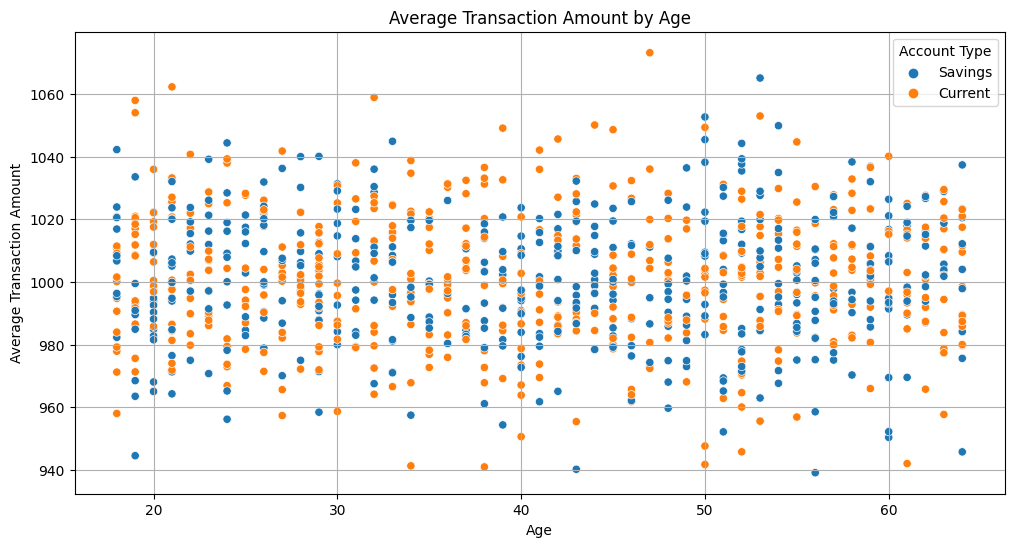

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Age', y='Average_Transaction_Amount', hue='Account_Type', data=data)
plt.title('Average Transaction Amount by Age')
plt.xlabel('Age')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Account Type')
plt.grid(True)
plt.show()


## Transactions by day of the week

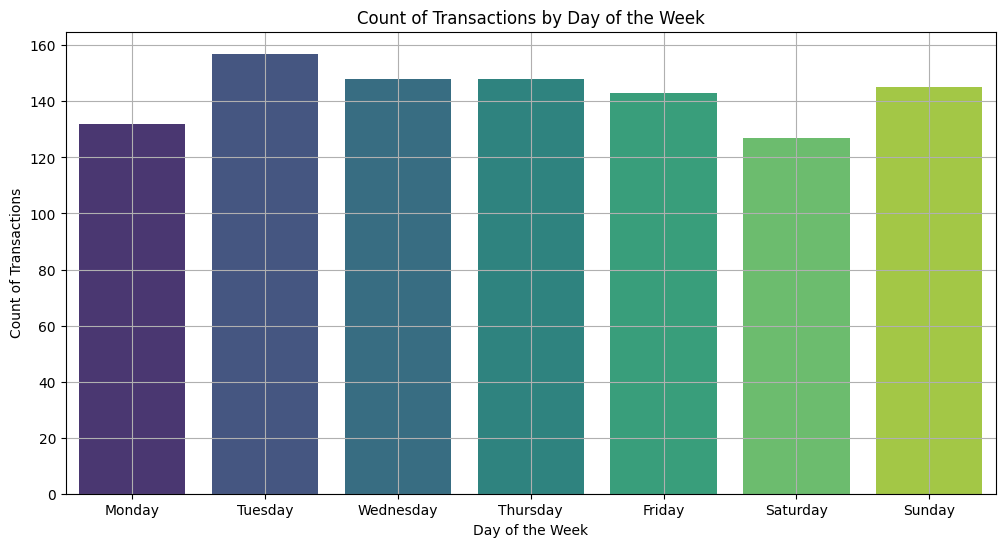

In [18]:
# Counting transactions
transaction_counts = data['Day_of_Week'].value_counts().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.figure(figsize=(12, 6))
sns.barplot(x=transaction_counts.index, y=transaction_counts.values, palette='viridis')
plt.title('Count of Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count of Transactions')
plt.grid(True)
plt.show()

## Correlation between all the columns

C:\Users\92310\AppData\Local\Temp\ipykernel_2168\3910941385.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


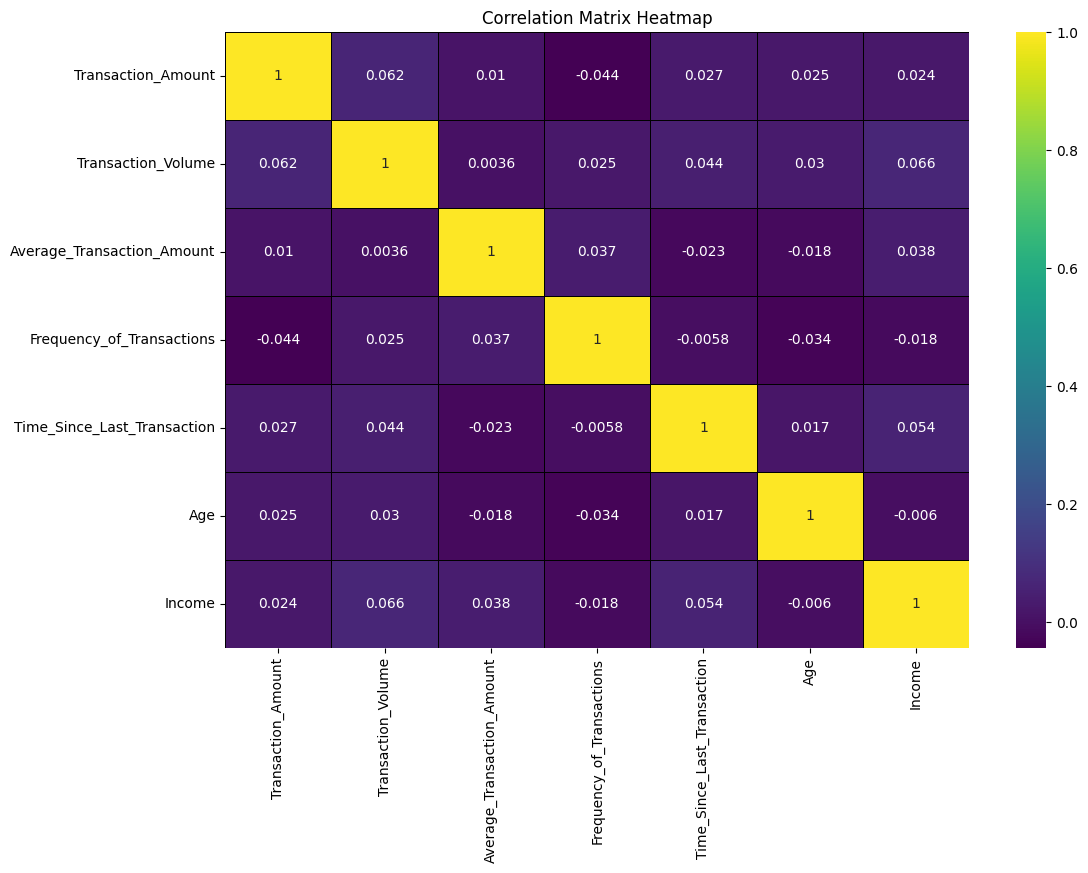

In [19]:
# Correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Anomalies in the data


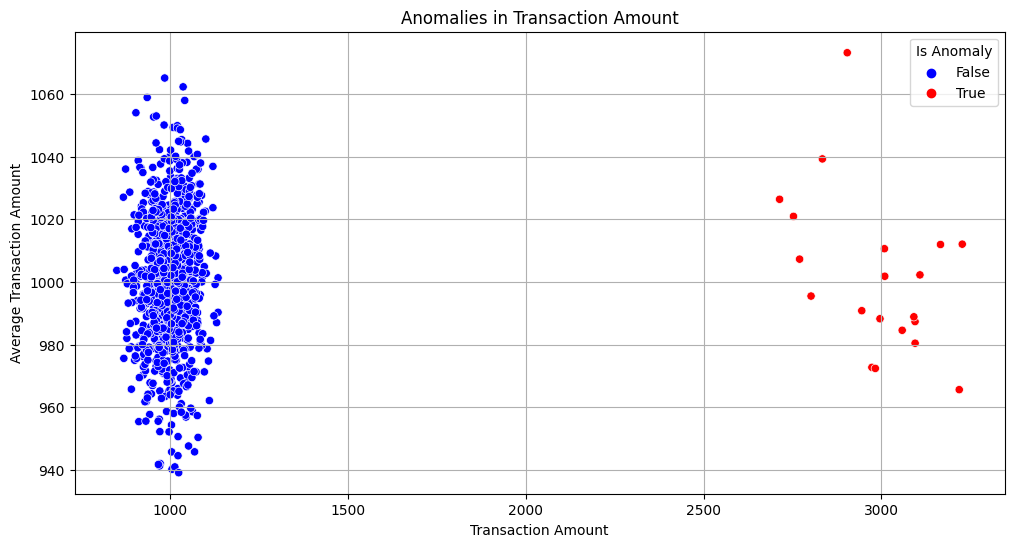

In [20]:
# Calculate Z-scores
data['Z_Score'] = (data['Transaction_Amount'] - data['Transaction_Amount'].mean()) / data['Transaction_Amount'].std()

# Define anomalies
data['Is_Anomaly'] = np.abs(data['Z_Score']) > 3

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Transaction_Amount', y='Average_Transaction_Amount', hue='Is_Anomaly', data=data, palette={True: 'red', False: 'blue'})
plt.title('Anomalies in Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Is Anomaly')
plt.grid(True)
plt.show()

## Calculating the number of anomalies

In [23]:
data['Z_Score'] = (data['Transaction_Amount'] - data['Transaction_Amount'].mean()) / data['Transaction_Amount'].std()

data['Is_Anomaly'] = np.abs(data['Z_Score']) > 3

num_anomalies = data['Is_Anomaly'].sum()

total_entries = len(data)

# Calculate the ratio of anomalies in the data
anomaly_ratio = num_anomalies / total_entries

num_anomalies, anomaly_ratio

(20, 0.02)

## Selecting the relevant features and fitting them into isolation forest

In [26]:
from sklearn.ensemble import IsolationForest

features = data[['Transaction_Amount', 'Average_Transaction_Amount']]

model = IsolationForest(contamination=0.02, random_state=42)
model.fit(features)

C:\Users\92310\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.02, random_state=42)

In [29]:
data['Anomaly_Score'] = model.decision_function(features)
data['Is_Anomaly'] = model.predict(features)

# Convert predictions to binary values
data['Is_Anomaly'] = data['Is_Anomaly'].apply(lambda x: 1 if x == -1 else 0)

print(data[['Transaction_ID', 'Transaction_Amount', 'Average_Transaction_Amount', 'Is_Anomaly']].head())

  Transaction_ID  Transaction_Amount  Average_Transaction_Amount  Is_Anomaly
0            TX0         1024.835708                  997.234714           0
1            TX1         1013.952065                 1020.210306           0
2            TX2          970.956093                  989.496604           0
3            TX3         1040.822254                  969.522480           0
4            TX4          998.777241                 1007.111026           0


## Classification report


In [32]:
from sklearn.metrics import classification_report

y_true = data['Is_Anomaly'] 
y_pred = data['Is_Anomaly']

report = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       980
     Anomaly       1.00      1.00      1.00        20

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## Using the trained model to detect anomalies

In [51]:
def predict_anomaly(transaction_amount, avg_transaction_amount, frequency_of_transactions):
    
    input_data = np.array([[transaction_amount, avg_transaction_amount, frequency_of_transactions]])
    
    prediction = model.predict(input_data)

    is_anomaly = 1 if prediction[0] == -1 else 0

    if is_anomaly:
        print("Anomaly detected: This transaction is flagged as an anomaly.")
    else:
        print("Normal transaction: This transaction is not flagged as an anomaly.")


def get_user_input_and_predict():
    try:
        transaction_amount = float(input("Enter the value for 'Transaction_Amount': "))
        avg_transaction_amount = float(input("Enter the value for 'Average_Transaction_Amount': "))
        frequency_of_transactions = int(input("Enter the value for 'Frequency_of_Transactions': "))
        
        predict_anomaly(transaction_amount, avg_transaction_amount, frequency_of_transactions)
    except ValueError:
        print("Invalid input. Please enter numeric values for 'Transaction_Amount' and 'Average_Transaction_Amount', and an integer for 'Frequency_of_Transactions'.")


In [52]:
# Example
transaction_amount = 10000
avg_transaction_amount = 900
frequency_of_transactions = 6

print("Using example values:")
predict_anomaly(transaction_amount, avg_transaction_amount, frequency_of_transactions)

Using example values:
Anomaly detected: This transaction is flagged as an anomaly.


C:\Users\92310\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
